---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

In [1]:
#| echo: false
import os
import numpy as np
from math import inf
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

This chapter demonstrates hyperparameter tuning for `river`'s `Mondrian Tree Regressor` [[SOURCE]](https://riverml.xyz/latest/api/forest/AMFRegressor/) with the Friedman drift data set [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). The `Mondrian Tree Regressor` is a regression tree, i.e., it predicts a real value for each sample.

## The Friedman Drift Data Set {#sec-the-friedman-drift-data-set-25}

The data set was introduced in @sec-the-friedman-drift-data-set-24.


In [2]:
#| label: 025_data_set

from river.datasets import synth
import pandas as pd
import numpy as np
from spotRiver.utils.data_conversion import convert_to_df

n_train = 6_000
n_test = 4_000
n_samples = n_train + n_test
target_column = "y"

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_train/4, n_train/2),
   seed=123
)

train = convert_to_df(dataset, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_test/4, n_test/2),
   seed=123
)
test = convert_to_df(dataset, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

## Setup

We will use a general experiment, data, evaluation, river-specific, objective-function, and surrogate setup  similar to the setup from @sec-setup-24.
Only the model setup differs from the setup in @sec-setup-24. Here we use the `Mondrian Tree Regressor` from `river`.


In [3]:
#| label: 025_model_setup
from spotRiver.hyperdict.river_hyper_dict import RiverHyperDict
core_model_name = "forest.AMFRegressor"
hyperdict = RiverHyperDict
hyperdict

spotRiver.hyperdict.river_hyper_dict.RiverHyperDict

### Select a User Hyperdictionary

Alternatively, you can load a local hyper_dict from the "userModel" folder. Here, we have selected a copy of the JSON `MondrianHyperDict` hyperdictionary from [[SOURCE]](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/userModel/mondrian_hyper_dict.json) and the `MondrianHyperDict` class from [[SOURCE]](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/userModel/mondrian_hyper_dict.py).
The hyperparameters of the `Mondrian Tree Regressor` are defined in the `MondrianHyperDict` class, i.e., there is an key "AMFRegressor" in the `hyperdict` "[mondrian_hyper_dict.json](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/userModel/mondrian_hyper_dict.json)" file.


In [4]:
#| label: 025_hyperdict_from_user_model
import sys
sys.path.insert(0, './userModel')
import mondrian_hyper_dict
hyperdict = mondrian_hyper_dict.MondrianHyperDict
hyperdict

mondrian_hyper_dict.MondrianHyperDict

In [5]:
#| label: 025_summary_control
from spotPython.utils.init import fun_control_init, design_control_init, surrogate_control_init, optimizer_control_init
from spotRiver.fun.hyperriver import HyperRiver

fun = HyperRiver().fun_oml_horizon

fun_control = fun_control_init(
    PREFIX="025",
    fun_evals=inf,
    max_time=1,

    prep_model_name="StandardScaler",
    test=test,
    train=train,
    target_column=target_column,

    metric_sklearn_name="mean_absolute_error",
    horizon=7*24,
    oml_grace_period=7*24,
    weight_coeff=0.0,
    weights=np.array([1, 0.01, 0.01]),

    core_model_name="forest.AMFRegressor",
    hyperdict=hyperdict,
   )


design_control = design_control_init(
    init_size=5,
)

surrogate_control = surrogate_control_init(
    noise=True,
    n_theta=2,
    min_Lambda=1e-3,
    max_Lambda=10,
)

optimizer_control = optimizer_control_init()

Seed set to 123


Created spot_tensorboard_path: runs/spot_logs/025_p040025_2024-07-10_21-08-00 for SummaryWriter()


## Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After the `core_model` and the ``hyperdict`` are added to the `fun_control` dictionary, the hyperparameter tuning can be started.
However, in some settings, the user wants to modify the hyperparameters. This can be done with the `set_int_hyperparameter_values`, `set_float_hyperparameter_values`, `set_boolean_hyperparameter_values`, and  `set_factor_hyperparameter_values`  functions, which can be imported from `from spotPython.hyperparameters.values` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py).

The following code shows how hyperparameter of type float and integer can be modified. Additional examples can be found in @sec-modifying-hyperparameter-levels.


In [6]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name            | type   |   default |   lower |   upper | transform             |
|-----------------|--------|-----------|---------|---------|-----------------------|
| n_estimators    | int    |         3 |     2   |      10 | transform_power_2_int |
| step            | float  |         1 |     0.1 |      10 | None                  |
| use_aggregation | factor |         1 |     0   |       1 | None                  |


In [7]:
from spotPython.hyperparameters.values import set_int_hyperparameter_values, set_float_hyperparameter_values, set_factor_hyperparameter_values
set_int_hyperparameter_values(fun_control, "n_estimators", 2, 7)
set_float_hyperparameter_values(fun_control, "step", 0.1, 15)
print(gen_design_table(fun_control))

Setting hyperparameter n_estimators to value [2, 7].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter step to value [0.1, 15].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
| name            | type   |   default |   lower |   upper | transform             |
|-----------------|--------|-----------|---------|---------|-----------------------|
| n_estimators    | int    |         3 |     2   |       7 | transform_power_2_int |
| step            | float  |         1 |     0.1 |      15 | None                  |
| use_aggregation | factor |         1 |     0   |       1 | None                  |


::: {.callout-note}
#### Note: Active and Inactive Hyperparameters
Hyperparameters can be excluded from the tuning procedure by selecting identical values for the lower and upper bounds.
:::

### Run the `Spot` Optimizer


In [8]:
#| label: 025_spot_run
from spotPython.spot import spot
spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control,
    optimizer_control=optimizer_control,
)
res = spot_tuner.run()

Seed set to 123


spotPython tuning: 2.8021966395993756 [#######---] 73.28% 


spotPython tuning: 2.8021966395993756 [##########] 100.00% Done...



We can start TensorBoard in the background with the following command, where ./runs is the default directory for the TensorBoard log files:

`tensorboard --logdir="./runs"`We can access the TensorBoard web server with the following URL:


```{raw}
http://localhost:6006/
```



## Results

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


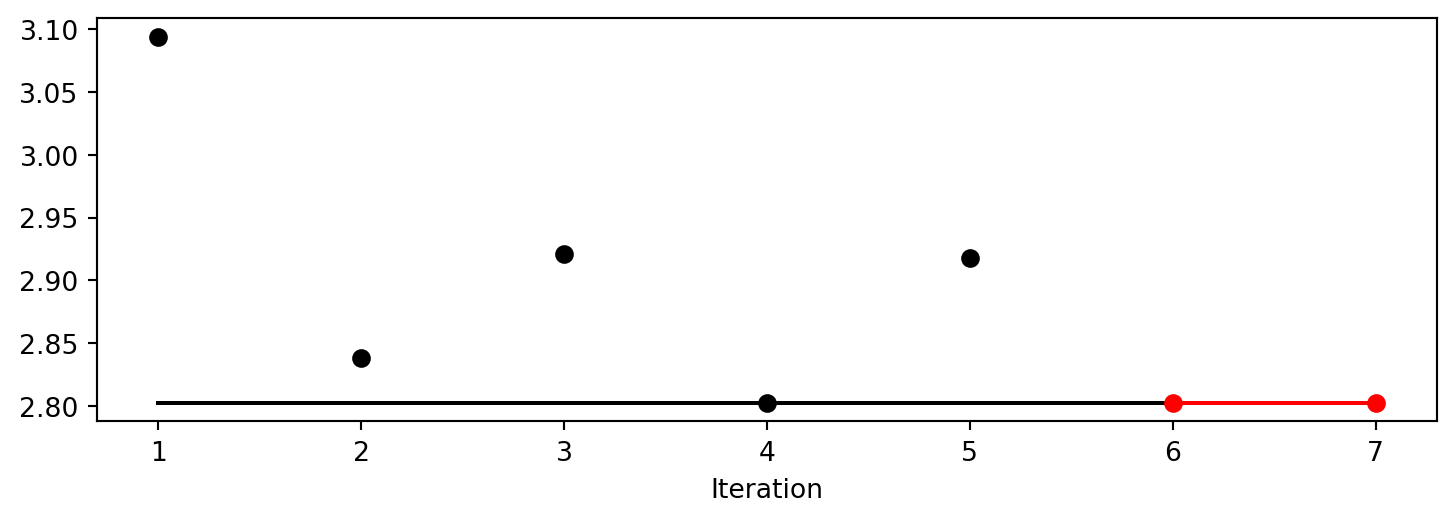

In [9]:
spot_tuner.plot_progress()

Results can be printed in tabular form.


In [10]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name            | type   |   default |   lower |   upper |              tuned | transform             |   importance | stars   |
|-----------------|--------|-----------|---------|---------|--------------------|-----------------------|--------------|---------|
| n_estimators    | int    |       3.0 |     2.0 |       7 |                5.0 | transform_power_2_int |       100.00 | ***     |
| step            | float  |       1.0 |     0.1 |      15 | 10.491348043415995 | None                  |         0.05 |         |
| use_aggregation | factor |       1.0 |     0.0 |       1 |                0.0 | None                  |         0.01 |         |


A histogram can be used to visualize the most important hyperparameters.


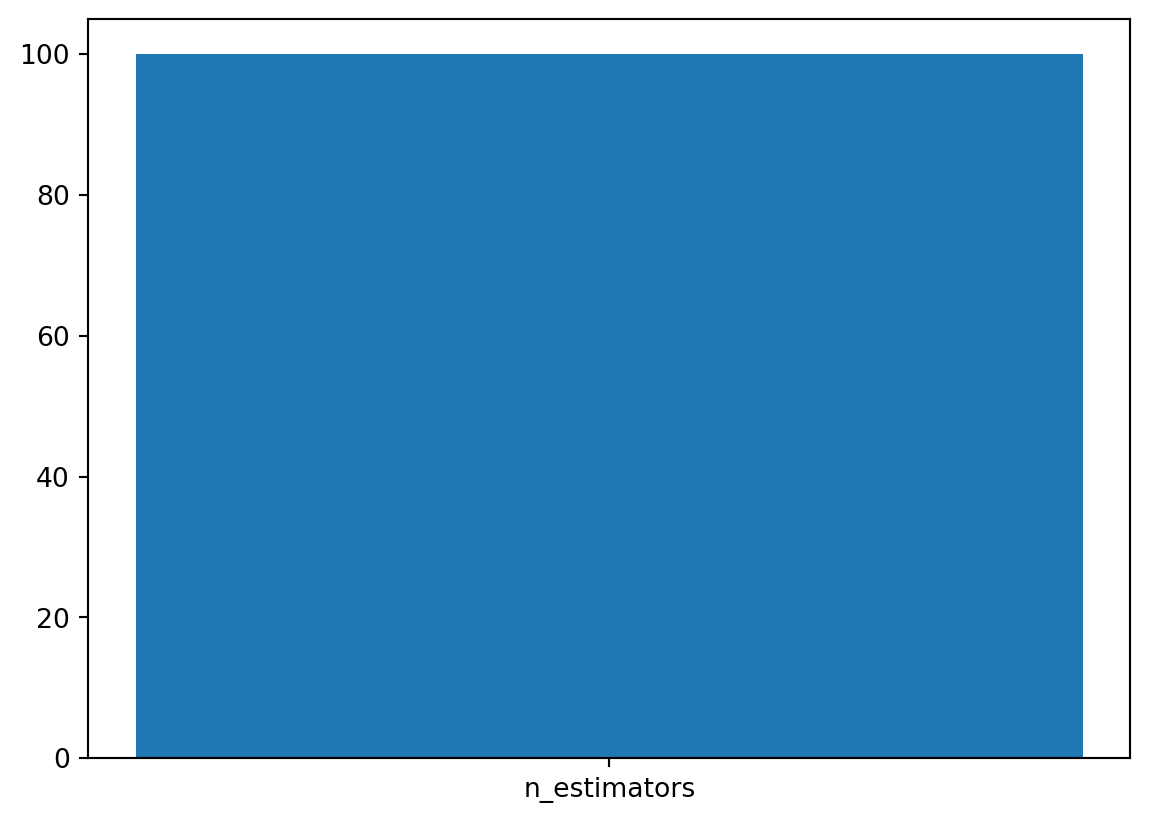

In [11]:
spot_tuner.plot_importance(threshold=10.0)

## Performance of the Model with Default Hyperparameters

### Get Default Hyperparameters and Fit the Model

The default hyperparameters, which will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:


In [12]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)

`spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.


In [13]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
model_default = get_one_core_model_from_X(X_start, fun_control, default=True)

### Evaluate the Model with Default Hyperparameters

The model with the default hyperparameters can be trained and evaluated.
The evaluation function `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py) is the same function that was used for the hyperparameter tuning.
During the hyperparameter tuning, the evaluation function was called from the objective (or loss) function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py).


In [14]:
#| label: 025_eval_default
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., score (metric), runtime, and memory consumption, can be visualized with the following commands:


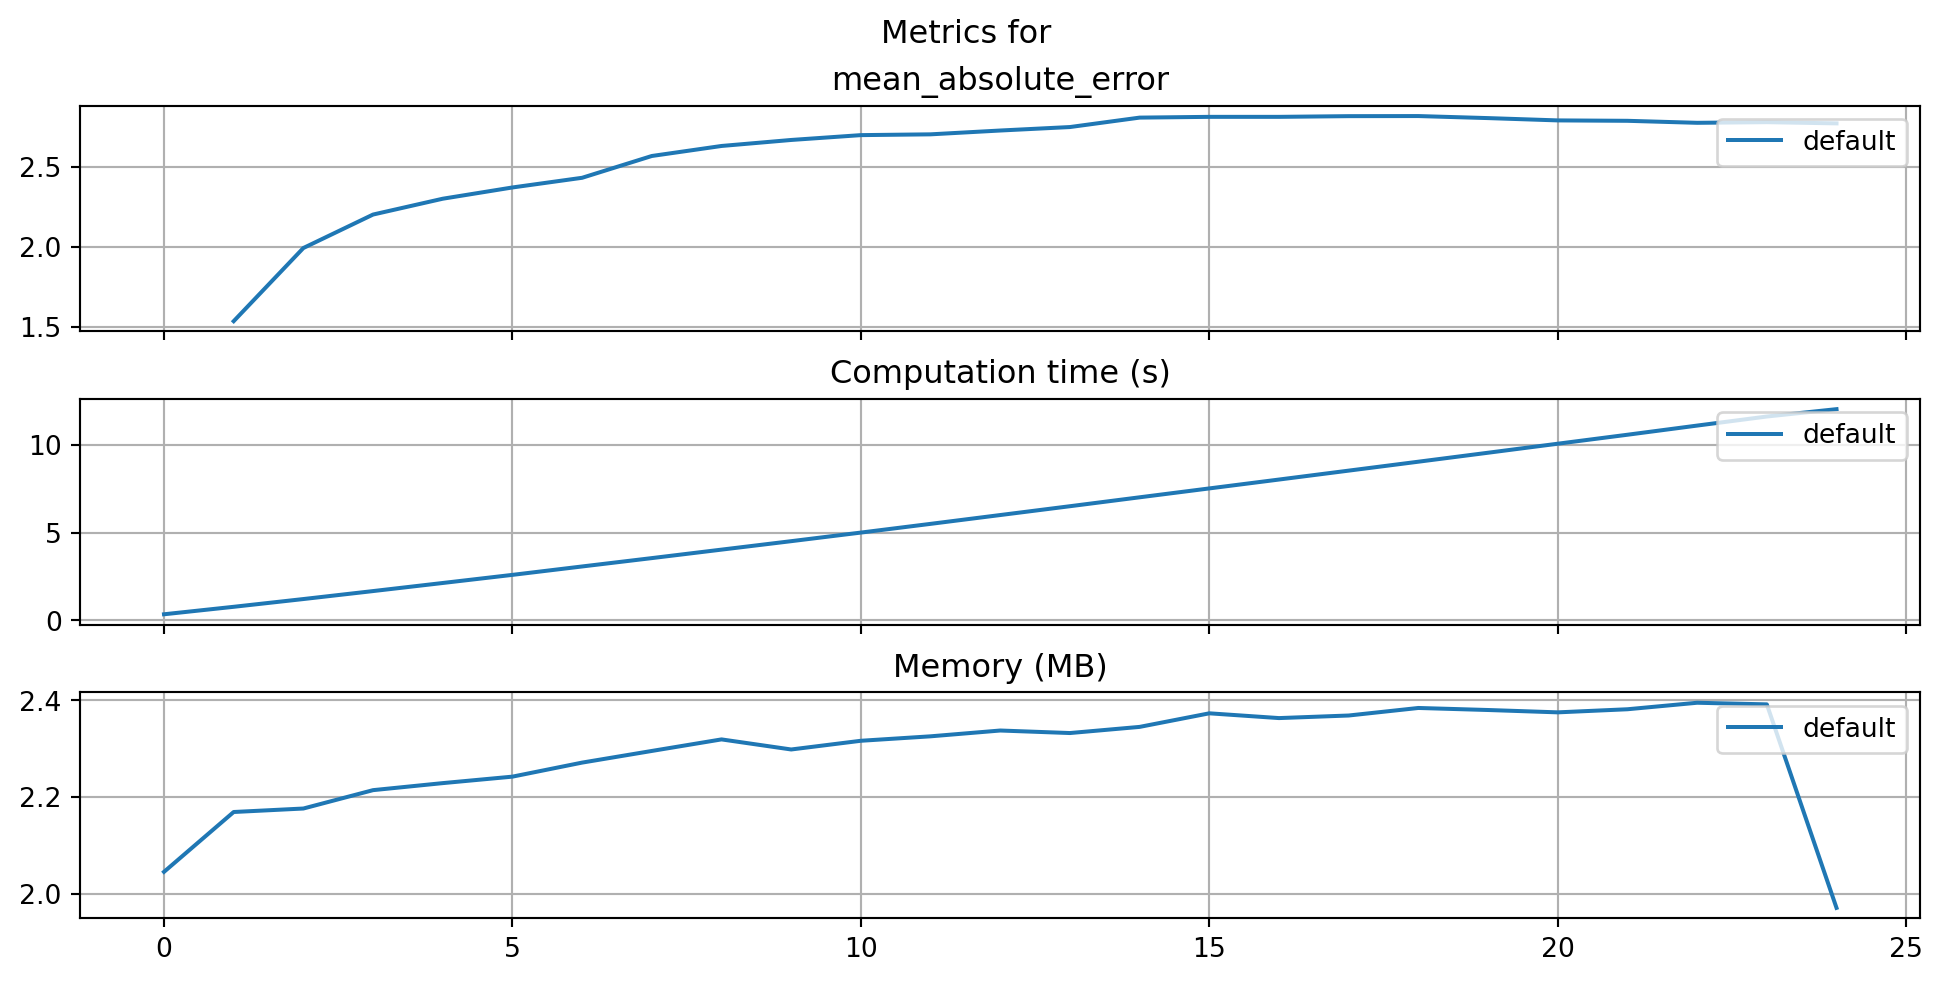

In [15]:
#| label: 025_plot_bml_oml_horizon_metrics_default
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions of the Model with Default Hyperparameters

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.


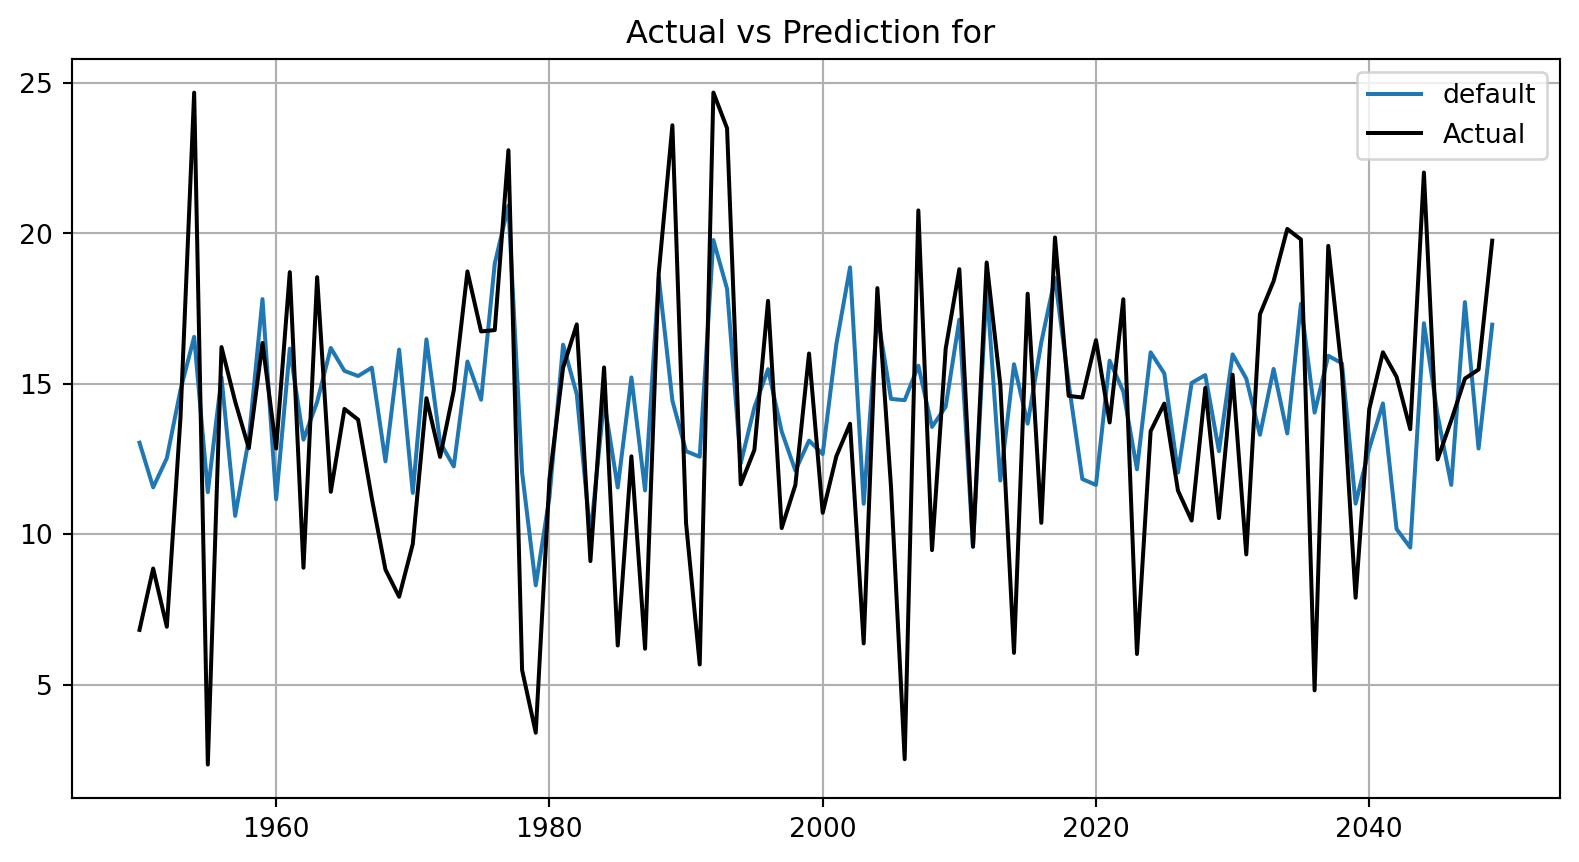

In [16]:
#| label: 025_plot_bml_oml_horizon_predictions_default
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)+50
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.


In [17]:
#| label: 025_get_one_core_model_from_X
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [18]:
#| label: 025_eval_om_horizon
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

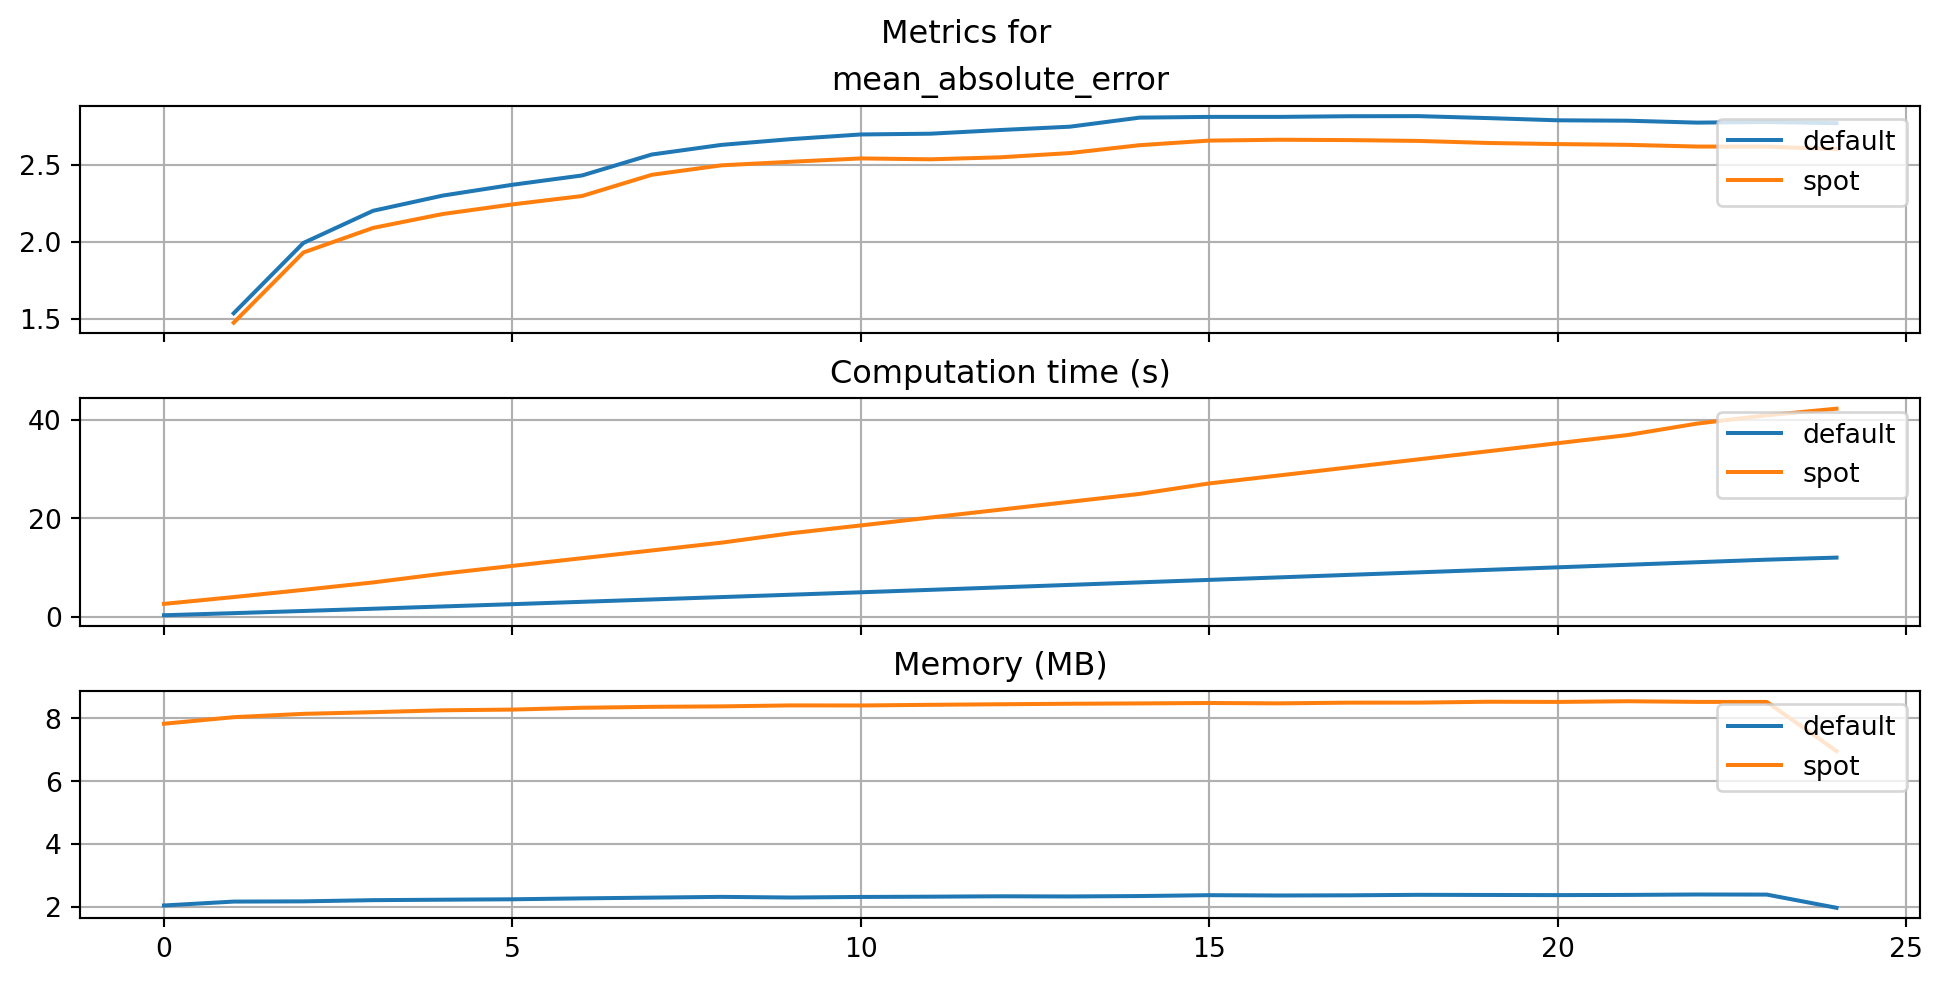

In [19]:
#| label: 025_plot_bml_oml_horizon_metrics
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

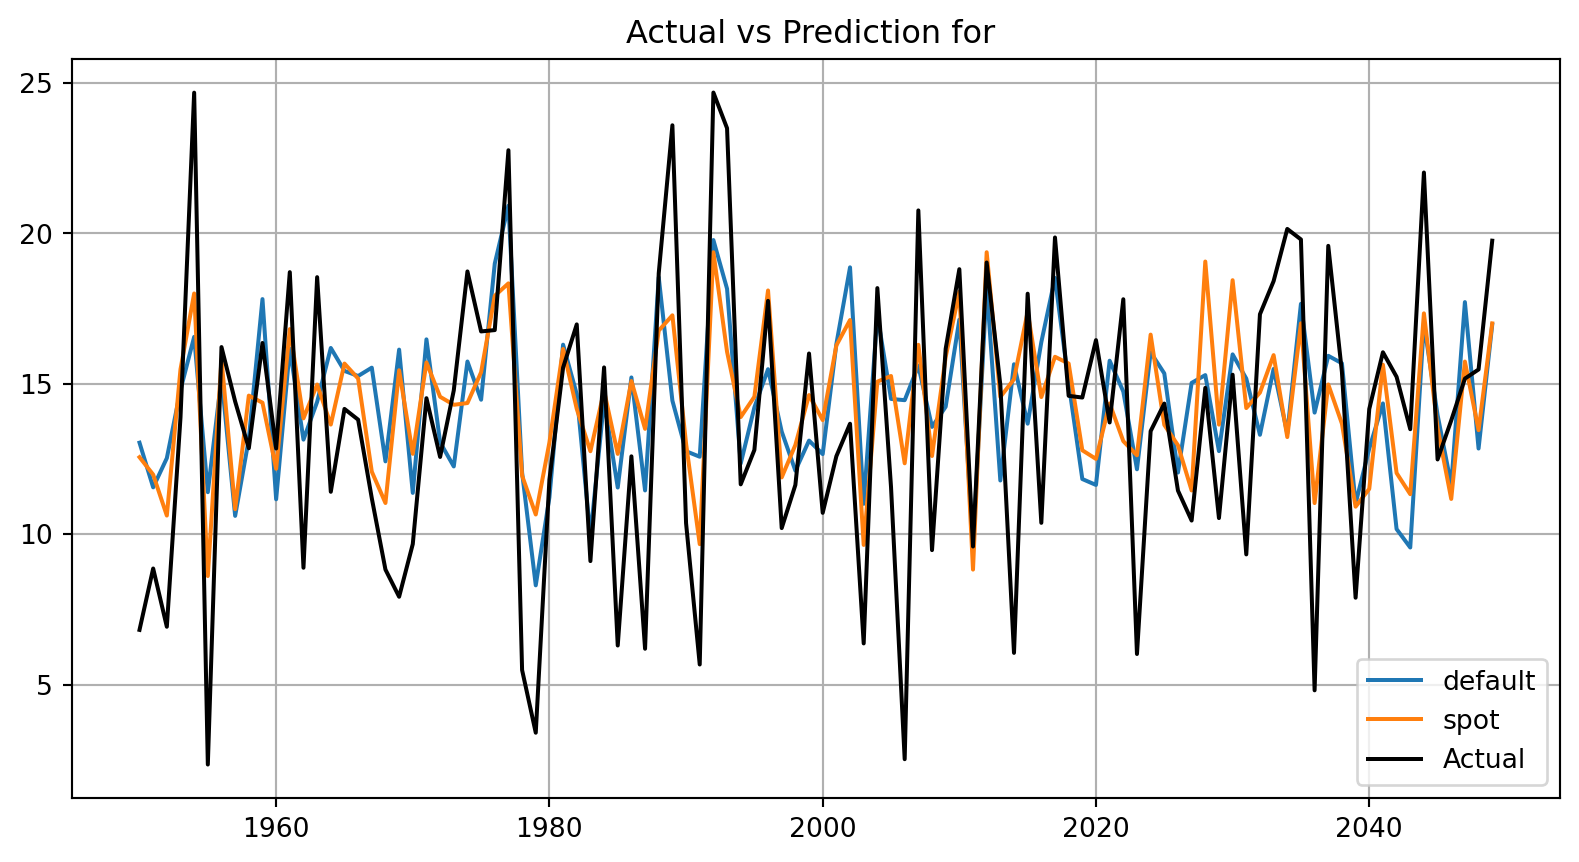

In [20]:
#| label: 025_plot_bml_oml_horizon_predictions
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels)

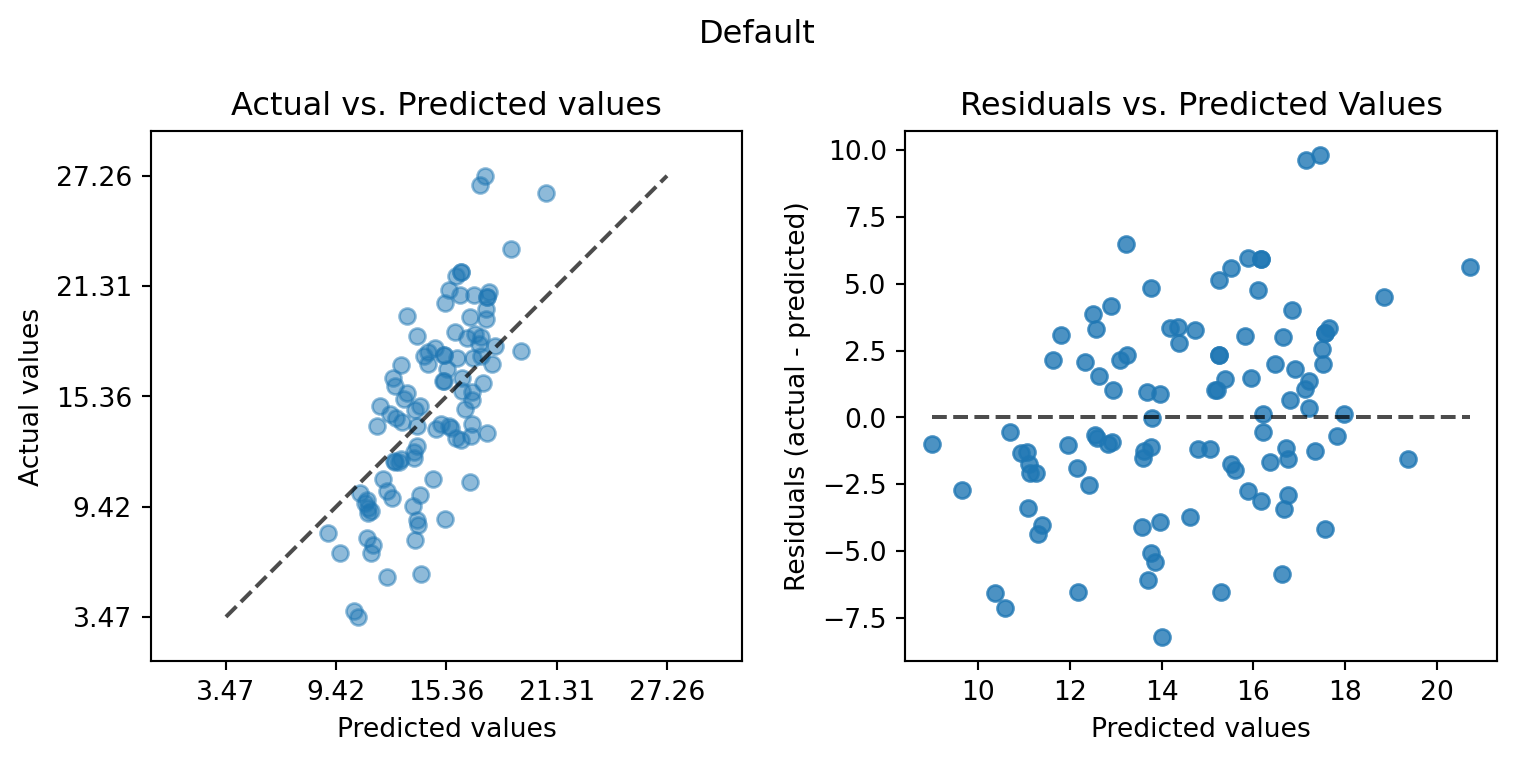

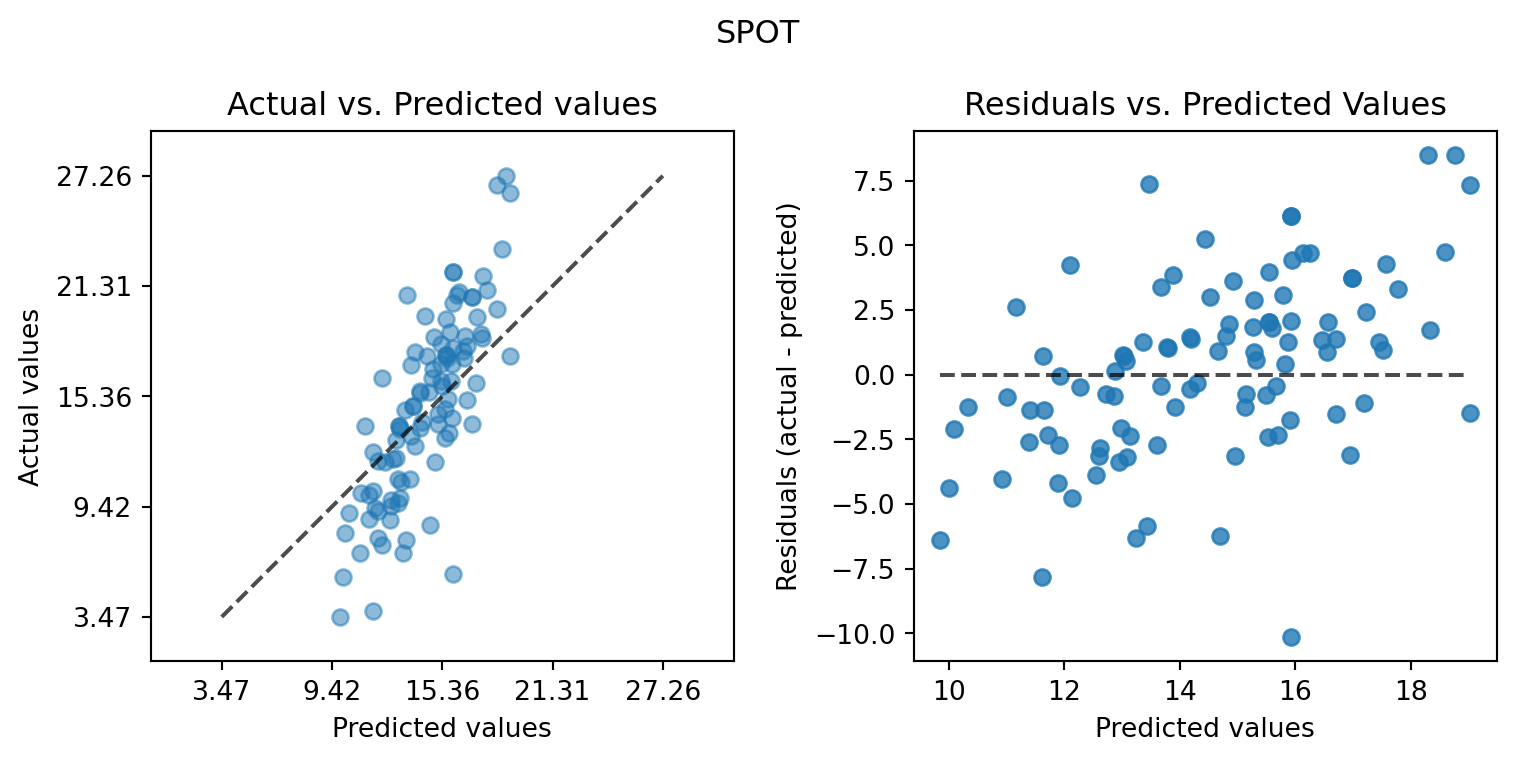

In [21]:
#| label: 025_plot_actual_vs_predicted
from spotPython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Detailed Hyperparameter Plots


n_estimators:  99.99999999999999
step:  0.04826826921448955
use_aggregation:  0.00836692004017717
impo: [['n_estimators', 99.99999999999999], ['step', 0.04826826921448955], ['use_aggregation', 0.00836692004017717]]
indices: [0, 1, 2]
indices after max_imp selection: [0, 1, 2]


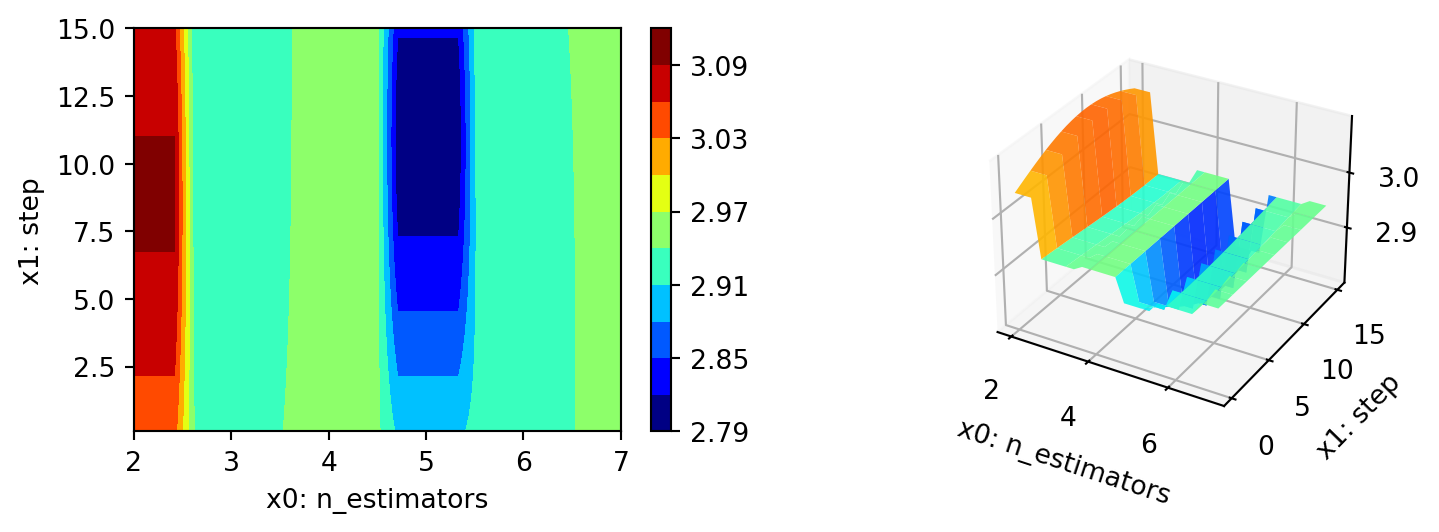

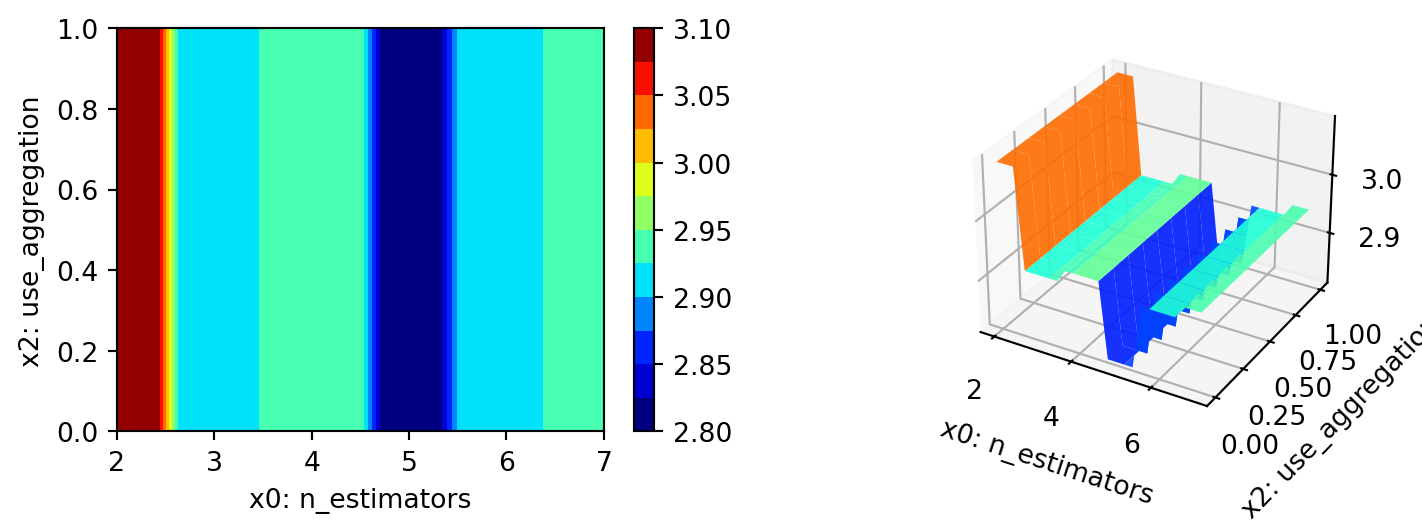

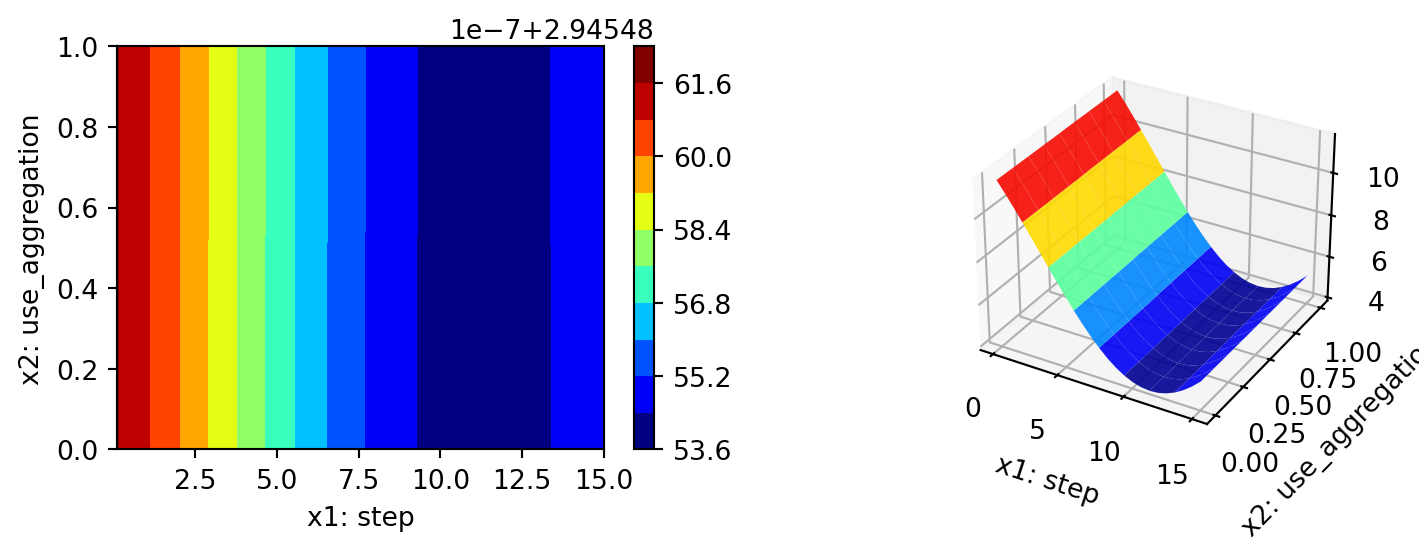

In [22]:
#| label: 025_plot_important_hyperparameter_contour
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

## Parallel Coordinates Plots


In [23]:
#| label: 025_parallel_plot
spot_tuner.parallel_plot()